In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
results = pd.read_csv("../RESULT/RESULTADOS-stemmer.csv", sep=";", converters={"DocInfos": pd.eval})
results.head()

,QueryNumber,DocInfos
0,1,"[1, 437, 0.27588934462955456]"
1,1,"[2, 498, 0.20844373959940954]"
2,1,"[3, 484, 0.18440699663023122]"
3,1,"[4, 754, 0.17310807431022798]"
4,1,"[5, 957, 0.16879740146000236]"


In [3]:
def get_expected_docs(expected_file_df):
    query_docs = {}
    query_numbers = list(expected_file_df["QueryNumber"].unique())
    for query_number in query_numbers:
        docs = list(expected_file_df.loc[expected_file_df["QueryNumber"] == query_number]["DocNumber"])
        query_docs[query_number] = docs
    return query_docs

def get_results_docs(results_file_df):
    results_docs = {}
    query_numbers = list(results_file_df["QueryNumber"].unique())
    for query_number in query_numbers:
        docs = []
        query_results = list(results_file_df.loc[results_file_df["QueryNumber"] == query_number]["DocInfos"])
        for single_result in query_results:
            doc_number = int(single_result[1])
            docs.append(doc_number)
        results_docs[query_number] = docs
    return results_docs

In [4]:
expected = pd.read_csv("../RESULT/ESPERADOS.csv", sep=";")
expected.head()

,QueryNumber,DocNumber,DocVotes
0,1,139,4
1,1,151,4
2,1,166,1
3,1,311,1
4,1,370,2


In [5]:
ex_docs = get_expected_docs(expected)
res_docs = get_results_docs(results)
ex_docs[1][:10] # não ordenado
res_docs[1][:10] # ordenado

[437, 498, 484, 754, 957, 533, 827, 499, 925, 441]

In [6]:
def precision(list_correct, list_return):
    total_correct = 0
    for doc_number in list_return:
        if doc_number in list_correct:
            total_correct += 1
    total_return = len(list_return)
    return total_correct / total_return * 100

def recall(doc_number, list_docs):
    total_docs = len(list_docs)
    if doc_number in list_docs:
        return 1 / total_docs * 100
    return 0.0

def pr_curve(expected_docs, results_docs, query_number):
    correct_docs = expected_docs[query_number]
    returned_docs = results_docs[query_number]
    plot_table = pd.DataFrame([], columns=["DocNumber", "Recall", "Precision"])
    r = 0.0
    for index, doc_number in enumerate(returned_docs):
        if recall(doc_number, correct_docs) == 0.0:
            continue
        r += recall(doc_number, correct_docs)
        p = precision(correct_docs, returned_docs[:index+1])
        plot_table.loc[index] = [int(doc_number), r, p]
    return plot_table

In [7]:
pr_curve(ex_docs, res_docs, 90)

,DocNumber,Recall,Precision
0,7.0,3.571429,100.000000
1,177.0,7.142857,100.000000
2,451.0,10.714286,100.000000
3,884.0,14.285714,100.000000
4,260.0,17.857143,100.000000
5,912.0,21.428571,100.000000
6,1090.0,25.000000,100.000000
7,479.0,28.571429,100.000000
8,778.0,32.142857,100.000000
10,589.0,35.714286,90.909091


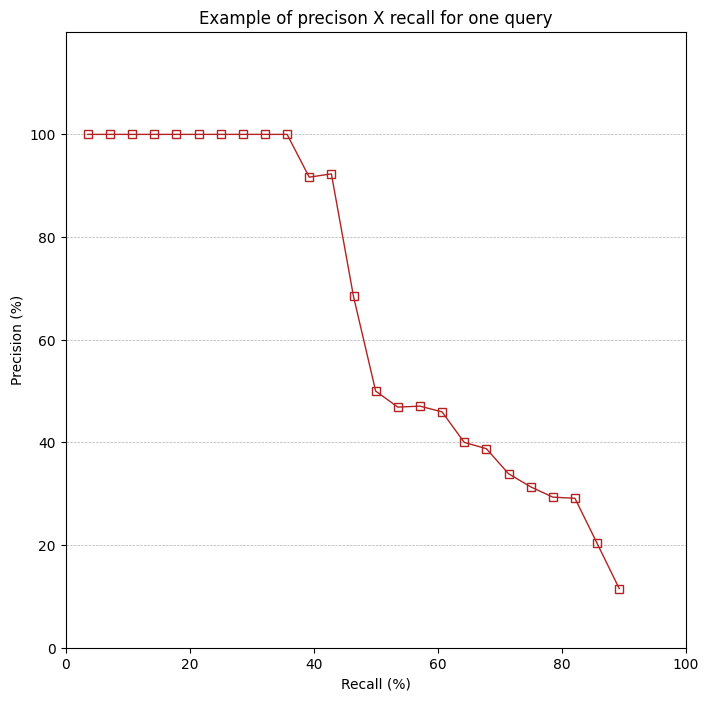

In [49]:
plt.figure(figsize=(8, 8))
plt.plot(pr_curve(ex_docs, res_docs, 90)["Recall"], pr_curve(ex_docs, res_docs, 90)["Precision"], 
         marker="s", markerfacecolor="none", ms=6, color="firebrick", linewidth=1)
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Example of precison X recall for one query")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])
plt.show()

In [50]:
def create_eleven_points_table(expected_docs, results_docs):
    table = pd.DataFrame([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], columns=["Recall"])
    query_numbers = list(expected_docs.keys())
    for query_number in query_numbers:
        eleven_points = pd.Series([], name=f"pQ{query_number}")
        curve = pr_curve(ex_docs, res_docs, query_number)
        for index, r in enumerate(range(0, 101, 10)):
            eleven_points[index] = curve.loc[curve["Recall"] > r]["Precision"].max()  
        table = pd.concat([table, eleven_points], axis=1)
    table.fillna(0, inplace=True)
    return table

eleven_points_df = create_eleven_points_table(ex_docs, res_docs)
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ90,pQ91,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100
0,0,33.333333,50.000000,50.000000,14.285714,100.000000,100.000000,100.000000,11.111111,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,66.666667,100.000000,100.000000,100.000000
1,10,33.333333,50.000000,19.565217,14.285714,70.000000,75.000000,19.354839,2.434457,50.000000,...,100.000000,33.027523,80.769231,35.714286,100.000000,50.000000,66.666667,66.666667,100.000000,100.000000
2,20,30.769231,50.000000,19.565217,14.285714,37.254902,35.714286,19.354839,2.434457,18.750000,...,100.000000,33.027523,59.090909,30.508475,100.000000,50.000000,44.444444,8.695652,100.000000,60.000000
3,30,25.490196,11.111111,11.475410,14.285714,36.363636,21.621622,6.172840,2.434457,12.500000,...,100.000000,32.517483,24.375000,30.508475,10.000000,40.000000,44.444444,2.684564,100.000000,17.391304
4,40,24.615385,11.111111,10.227273,14.285714,0.000000,14.925373,5.940594,2.434457,12.500000,...,92.307692,31.578947,16.455696,30.508475,3.076923,15.151515,30.000000,2.684564,100.000000,2.333333
5,50,19.354839,1.416431,7.119741,14.285714,0.000000,10.317460,4.155844,2.434457,11.666667,...,47.058824,30.099010,14.883721,0.000000,0.978474,5.343511,30.000000,2.684564,100.000000,2.333333
6,60,17.213115,1.416431,5.739514,7.142857,0.000000,7.804878,3.786192,0.000000,11.666667,...,45.945946,0.000000,12.866450,0.000000,0.855920,4.347826,12.727273,0.000000,1.428571,2.333333
7,70,7.228916,1.416431,5.414552,5.384615,0.000000,5.120482,3.418803,0.000000,10.810811,...,33.898305,0.000000,0.000000,0.000000,0.000000,1.939655,8.888889,0.000000,1.428571,2.237136
8,80,3.846154,0.000000,5.124451,4.878049,0.000000,2.945302,2.909091,0.000000,5.263158,...,29.113924,0.000000,0.000000,0.000000,0.000000,1.082251,4.639175,0.000000,1.187648,2.237136
9,90,0.000000,0.000000,4.581901,0.000000,0.000000,2.813299,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.582734,0.000000,1.187648,2.237136


In [51]:
def add_mean_precision(eleven_points_df):
    pi = pd.Series([], name="pi")
    copy_11 = eleven_points_df.set_index(["Recall"])
    n_columns = len(copy_11.columns)
    for i in range(11):
        pi.loc[i] = copy_11.loc[i * 10].sum() / n_columns  
    eleven_points_df = pd.concat([eleven_points_df, pi], axis=1)
    return eleven_points_df

eleven_points_df = add_mean_precision(eleven_points_df)
eleven_points_df.to_csv("../AVALIA/11pontos-nostemmer-1.csv")
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ91,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100,pi
0,0,33.333333,50.000000,50.000000,14.285714,100.000000,100.000000,100.000000,11.111111,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,66.666667,100.000000,100.000000,100.000000,81.695194
1,10,33.333333,50.000000,19.565217,14.285714,70.000000,75.000000,19.354839,2.434457,50.000000,...,33.027523,80.769231,35.714286,100.000000,50.000000,66.666667,66.666667,100.000000,100.000000,57.086341
2,20,30.769231,50.000000,19.565217,14.285714,37.254902,35.714286,19.354839,2.434457,18.750000,...,33.027523,59.090909,30.508475,100.000000,50.000000,44.444444,8.695652,100.000000,60.000000,39.747964
3,30,25.490196,11.111111,11.475410,14.285714,36.363636,21.621622,6.172840,2.434457,12.500000,...,32.517483,24.375000,30.508475,10.000000,40.000000,44.444444,2.684564,100.000000,17.391304,29.121854
4,40,24.615385,11.111111,10.227273,14.285714,0.000000,14.925373,5.940594,2.434457,12.500000,...,31.578947,16.455696,30.508475,3.076923,15.151515,30.000000,2.684564,100.000000,2.333333,22.965155
5,50,19.354839,1.416431,7.119741,14.285714,0.000000,10.317460,4.155844,2.434457,11.666667,...,30.099010,14.883721,0.000000,0.978474,5.343511,30.000000,2.684564,100.000000,2.333333,16.163205
6,60,17.213115,1.416431,5.739514,7.142857,0.000000,7.804878,3.786192,0.000000,11.666667,...,0.000000,12.866450,0.000000,0.855920,4.347826,12.727273,0.000000,1.428571,2.333333,10.995489
7,70,7.228916,1.416431,5.414552,5.384615,0.000000,5.120482,3.418803,0.000000,10.810811,...,0.000000,0.000000,0.000000,0.000000,1.939655,8.888889,0.000000,1.428571,2.237136,7.294236
8,80,3.846154,0.000000,5.124451,4.878049,0.000000,2.945302,2.909091,0.000000,5.263158,...,0.000000,0.000000,0.000000,0.000000,1.082251,4.639175,0.000000,1.187648,2.237136,4.105509
9,90,0.000000,0.000000,4.581901,0.000000,0.000000,2.813299,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.582734,0.000000,1.187648,2.237136,1.507082


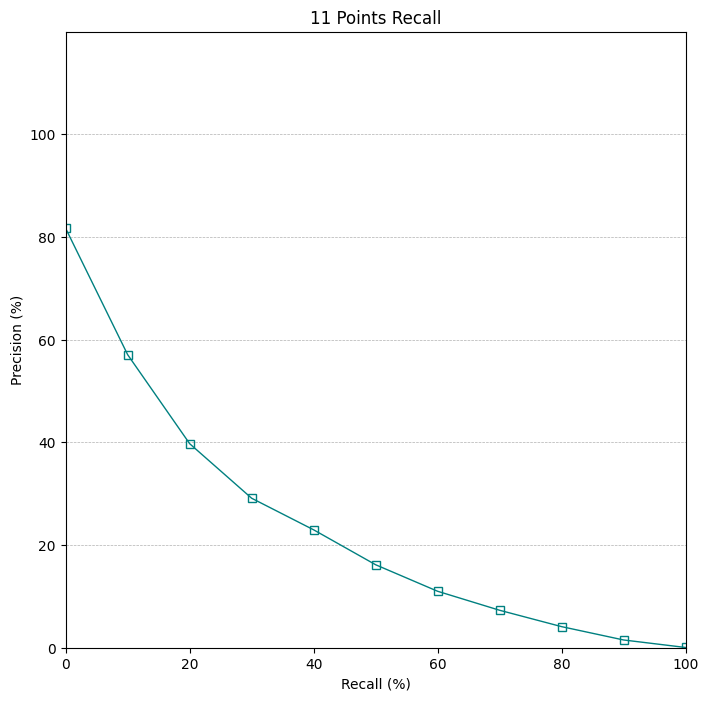

In [52]:
plt.figure(figsize=(8, 8))
plt.plot(eleven_points_df["Recall"], eleven_points_df["pi"], 
         marker="s", markerfacecolor="none", ms=6, color="teal", linewidth=1)
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("11 Points Recall")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])
plt.savefig("../AVALIA/11pontos-nostemmer-1.png")
plt.show()

In [53]:
def query_recall(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
    relevant_total = len(relevant_docs)
    return relevant_retrieved / relevant_total

def query_precision(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
    retrieved_total = len(retrieved_docs)
    return relevant_retrieved / retrieved_total

r = query_recall(ex_docs, res_docs, 90)
p = query_precision(ex_docs, res_docs, 90)
print(f"Recall = {r}\nPrecision = {p}")

Recall = 0.8928571428571429
Precision = 0.03221649484536082


In [54]:
def f1_score(p, r):
    return (2*p*r) / (p+r)

def get_f1_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    f1_table = pd.DataFrame([], columns=["F1", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        r = query_recall(expected_docs, results_docs, query_number)
        p = query_precision(expected_docs, results_docs, query_number)
        f1 = f1_score(p, r)
        f1_table.loc[index] = [f1, query_number]
    return f1_table

f1 = get_f1_table(ex_docs, res_docs)
f1.to_csv("../AVALIA/f1-nostemmer-3.csv")
f1.head()

,F1,QueryNumber
0,0.069628,1.0
1,0.020243,2.0
2,0.084926,3.0
3,0.082902,4.0
4,0.305455,5.0


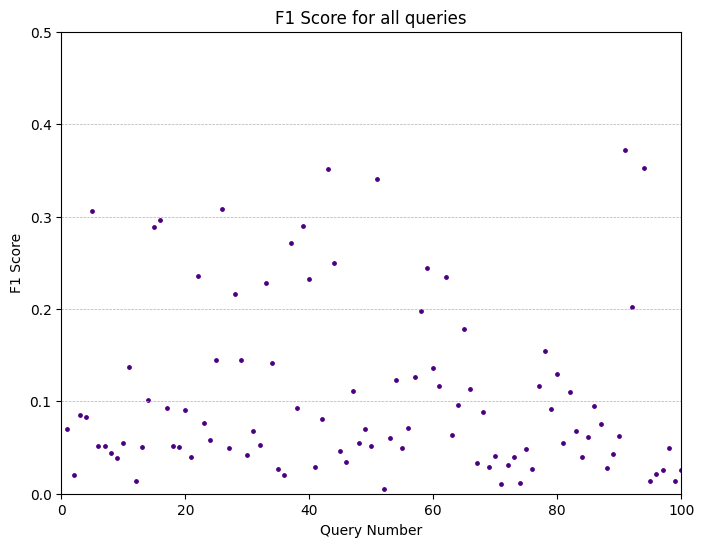

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(f1["QueryNumber"], f1["F1"], s=6, c="indigo")
plt.axis([0, 100, 0, 0.5])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("F1 Score for all queries")
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.show()

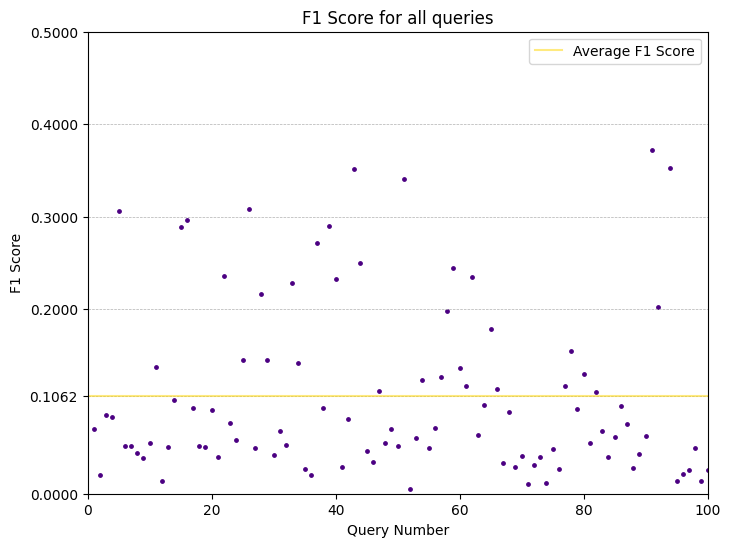

In [78]:
def get_avg_f1(f1_table):
    return f1_table["F1"].sum() / len(f1_table["F1"])

avg_f1 = get_avg_f1(f1)

plt.figure(figsize=(8, 6))
plt.scatter(f1["QueryNumber"], f1["F1"], s=6, c="indigo")
plt.axhline(avg_f1, alpha=0.5, color="gold", label="Average F1 Score")
plt.axis([0, 100, 0, 0.5])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("F1 Score for all queries")
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.yticks([0, avg_f1, 0.2, 0.3, 0.4, 0.5])
plt.legend()
plt.savefig("../AVALIA/f1-nostemmer-3.png")
plt.show()

In [57]:
correct_list = ex_docs[90]
returned_list = res_docs[90]
precision(correct_list, returned_list[:10])

100.0

In [58]:
def get_precision_at_k(k, expected_docs, results_docs, query_number):
    correct_list = expected_docs[query_number]
    returned_list = results_docs[query_number]
    return precision(correct_list, returned_list[:k])

def get_p_at_k_table(k, expected_docs, results_docs):
    query_numbers = list(ex_docs.keys())
    pk_table = pd.DataFrame([], columns=[f"P@{k}", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        pk = get_precision_at_k(k, expected_docs, results_docs, query_number)
        pk_table.loc[index] = [pk, query_number]
    return pk_table

p5 = get_p_at_k_table(5, ex_docs, res_docs)
p10 = get_p_at_k_table(10, ex_docs, res_docs)
p5.to_csv("../AVALIA/precision@5-nostemmer-5.csv")
p10.to_csv("../AVALIA/precision@10-nostemmer-7.csv")

get_p_at_k_table(3, ex_docs, res_docs).head()

,P@3,QueryNumber
0,0.000000,1.0
1,33.333333,2.0
2,33.333333,3.0
3,0.000000,4.0
4,66.666667,5.0


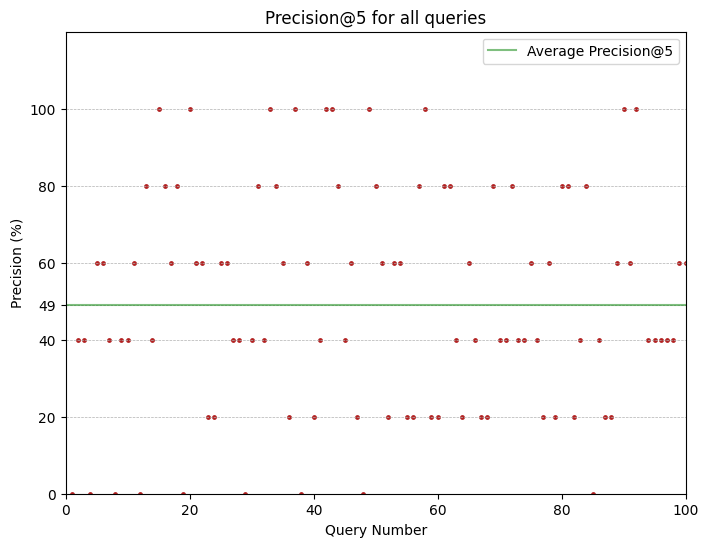

In [59]:
def get_avg_p_at_k(k, pk_table):
    return pk_table[f"P@{k}"].sum() / len(pk_table[f"P@{k}"])

plt.figure(figsize=(8, 6))
plt.scatter(p5["QueryNumber"], p5["P@5"], s=6, c="firebrick")
plt.axhline(get_avg_p_at_k(5, p5), alpha=0.5, color="green", label="Average Precision@5")
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Precision@5 for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, get_avg_p_at_k(5, p5), 60, 80, 100])
plt.legend()
plt.savefig("../AVALIA/precision@5-nostemmer-5.png")
plt.show()

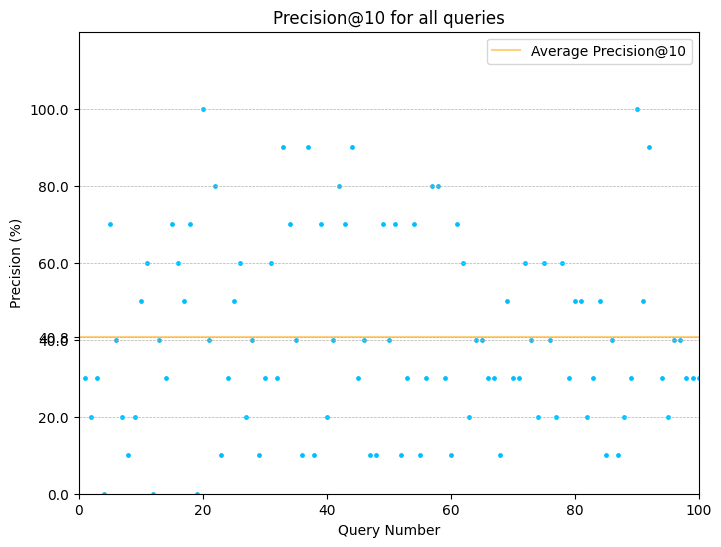

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(p10["QueryNumber"], p10["P@10"], s=6, c="deepskyblue")
plt.axhline(get_avg_p_at_k(10, p10), alpha=0.5, color="orange", label="Average Precision@10")
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Precision@10 for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, get_avg_p_at_k(10, p10), 60, 80, 100])
plt.legend()
plt.savefig("../AVALIA/precision@10-nostemmer-7.png")
plt.show()

In [9]:
def get_r_precision(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    relevant_total = len(relevant_docs)
    total = relevant_total
    retrieved_total = len(retrieved_docs)
    if relevant_total > retrieved_total:
        total = retrieved_total
    correct_retrieved = 0
    for i in range(total):
        if retrieved_docs[i] in relevant_docs:
            correct_retrieved += 1
    return correct_retrieved / relevant_total * 100

def get_r_precision_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    r_precision_table = pd.DataFrame([], columns=[f"R-Precision", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        rp = get_r_precision(expected_docs, results_docs, query_number)
        r_precision_table.loc[index] = [rp, query_number]    
    return r_precision_table

r_precision_stemmer = get_r_precision_table(ex_docs, res_docs)
r_precision_stemmer.head()

,R-Precision,QueryNumber
0,23.529412,1.0
1,28.571429,2.0
2,16.279070,3.0
3,11.111111,4.0
4,33.587786,5.0


In [10]:
results_nostemmer = pd.read_csv("../RESULT/RESULTADOS-nostemmer.csv", sep=";", converters={"DocInfos": pd.eval})
nostemmer_res_docs = get_results_docs(results_nostemmer)

r_precision_nostemmer = get_r_precision_table(ex_docs, nostemmer_res_docs)
r_precision_nostemmer.head()

,R-Precision,QueryNumber
0,26.470588,1.0
1,28.571429,2.0
2,18.604651,3.0
3,0.000000,4.0
4,32.061069,5.0


In [11]:
diff_r_precision = r_precision_stemmer.rename(columns={"R-Precision": "Diff-R-Precision"})
diff_r_precision["Diff-R-Precision"] = r_precision_stemmer["R-Precision"] - r_precision_nostemmer["R-Precision"]
diff_r_precision.to_csv("../AVALIA/r-precision-comparativo-9.csv")
diff_r_precision.tail()

,Diff-R-Precision,QueryNumber
94,-8.333333,96.0
95,-9.090909,97.0
96,0.000000,98.0
97,0.000000,99.0
98,0.000000,100.0


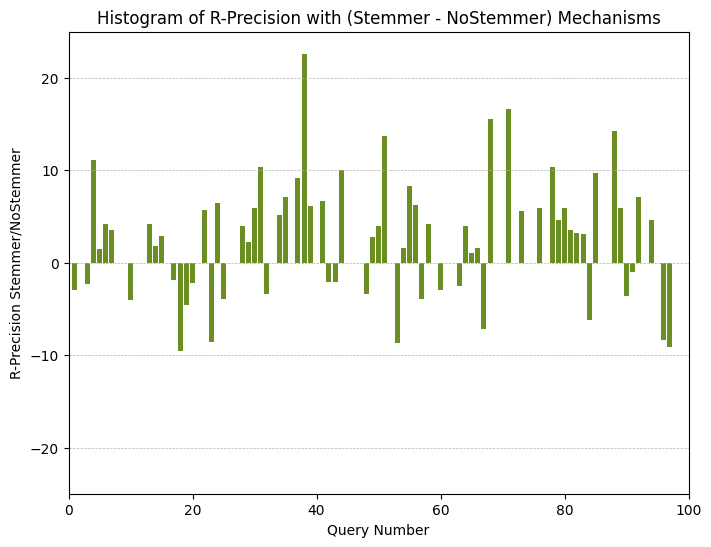

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(diff_r_precision["QueryNumber"], diff_r_precision["Diff-R-Precision"], color="olivedrab")
plt.axis([0, 100, -25, 25])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Histogram of R-Precision with (Stemmer - NoStemmer) Mechanisms")
plt.xlabel("Query Number")
plt.ylabel("R-Precision Stemmer/NoStemmer")
plt.savefig("../AVALIA/r-precision-comparativo-9.png")
plt.show()

In [65]:
def get_mvp(expected_docs, results_docs, query_number):
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    precisions = []
    for index, doc_number in enumerate(retrieved_docs):
        if doc_number in relevant_docs:
            p = precision(relevant_docs, retrieved_docs[:index+1])
            precisions.append(p)
    while len(precisions) < len(relevant_docs):
        precisions.append(0.0)
    total = 0
    for v in precisions:
        total += v
    mvp = total / len(precisions)
    return mvp

def get_mvp_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    mvp_table = pd.DataFrame([], columns=["MVP", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        mvp = get_mvp(expected_docs, results_docs, query_number)
        mvp_table.loc[index] = [mvp, query_number]
    return mvp_table

mvp = get_mvp_table(ex_docs, res_docs)
mvp.to_csv("../AVALIA/map-nostemmer-10.csv")
mvp.head()

,MVP,QueryNumber
0,16.363140,1.0
1,13.861008,2.0
2,11.079499,3.0
3,8.448681,4.0
4,15.952096,5.0


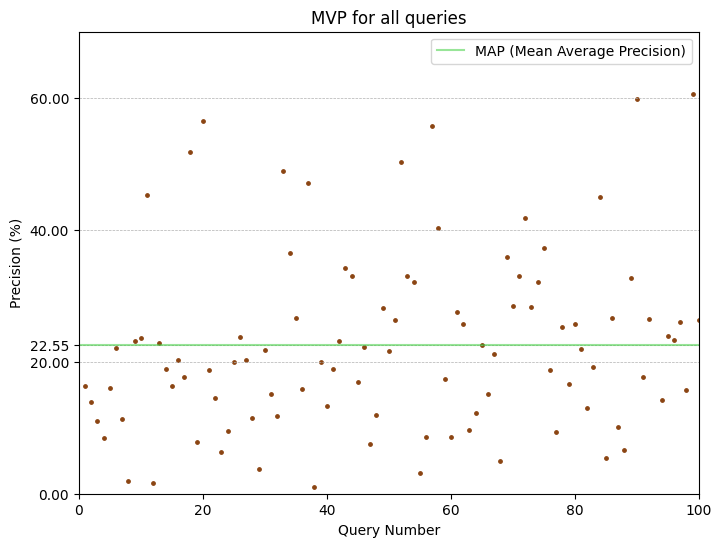

In [66]:
def get_map(mvp_table):
    return mvp_table["MVP"].sum() / len(mvp_table["MVP"])

plt.figure(figsize=(8, 6))
plt.scatter(mvp["QueryNumber"], mvp["MVP"], s=6, c="saddlebrown")
plt.axhline(get_map(mvp), alpha=0.5, color="limegreen", label="MAP (Mean Average Precision)")
plt.axis([0, 100, 0, 70])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("MVP for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, get_map(mvp), 40, 60])
plt.legend()
plt.savefig("../AVALIA/map-nostemmer-10.png")
plt.show()

In [67]:
def get_rr(expected_docs, results_docs, query_number):
    k = 10
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number][:k]
    for position, doc_number in enumerate(retrieved_docs):
        if doc_number in relevant_docs:
            return 1 / (position + 1) * 100
    return 0.0

def get_rr_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    rr_table = pd.DataFrame([], columns=["RR", "QueryNumber"])
    for index, query_number in enumerate(query_numbers):
        rr = get_rr(expected_docs, results_docs, query_number)
        rr_table.loc[index] = [rr, query_number]
    return rr_table

rr = get_rr_table(ex_docs, res_docs)
rr.to_csv("../AVALIA/mrr-nostemmer-12.csv")
rr.head()

,RR,QueryNumber
0,16.666667,1.0
1,33.333333,2.0
2,50.000000,3.0
3,0.000000,4.0
4,100.000000,5.0


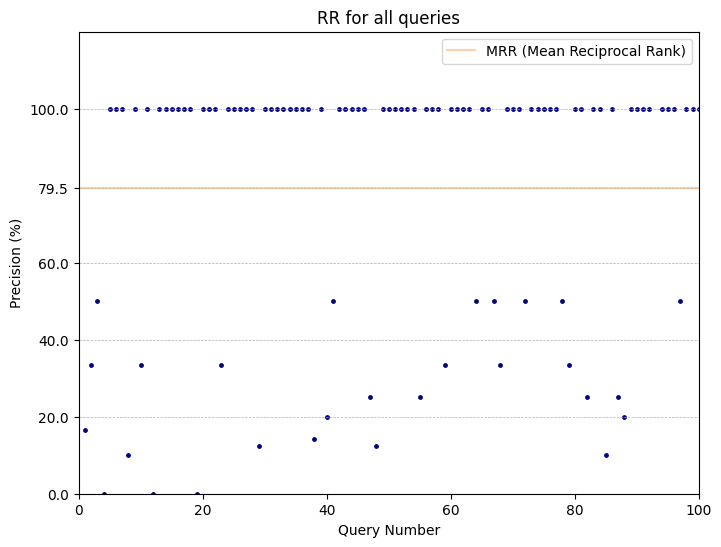

In [68]:
def get_mrr(rr_table):
    return rr_table["RR"].sum() / len(rr_table["RR"])

plt.figure(figsize=(8, 6))
plt.scatter(rr["QueryNumber"], rr["RR"], s=6, c="navy")
plt.axhline(get_mrr(rr), alpha=0.5, color="sandybrown", label="MRR (Mean Reciprocal Rank)")
plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("RR for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60,  get_mrr(rr), 100])
plt.legend()
plt.savefig("../AVALIA/mrr-nostemmer-12.png")
plt.show()

In [69]:
def get_gain(query_number, doc_number):
    expected_query = expected.loc[expected["QueryNumber"] == query_number]
    expected_doc = expected_query.loc[expected["DocNumber"] == doc_number]
    gain = expected_doc["DocVotes"]
    if gain.empty:
        return 0
    else:
        i = list(gain.index)[0]
        return gain[i]

def get_dcg(results_docs, query_number):
    k = 10
    retrieved_docs = results_docs[query_number][:k]
    cg_vector = []
    for doc_number in retrieved_docs:
        gain = get_gain(query_number, doc_number)
        cg_vector.append(gain)
    dcg = [cg_vector[0]]
    for i in range(1, k):
        dcg_i = dcg[i-1] + (cg_vector[i] / math.log2(i + 1))
        dcg.append(dcg_i)
    return dcg

get_dcg(res_docs, 90)

[np.int64(4),
 np.float64(8.0),
 np.float64(10.523719014285831),
 np.float64(12.523719014285831),
 np.float64(13.81574868850601),
 np.float64(15.363159917444177),
 np.float64(16.431781478768244),
 np.float64(17.09844814543491),
 np.float64(17.41391302222064),
 np.float64(17.71494301788462)]

In [70]:
def get_dcg_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    dcg_table = pd.DataFrame([], columns=["QueryNumber"])
    for i in range(1, 11):
        dcg_table[i] = 0
    for index, query_number in enumerate(query_numbers):
        dcg = get_dcg(results_docs, query_number)
        dcg_table.loc[index] = [query_number, *dcg]
    return dcg_table

dcg = get_dcg_table(ex_docs, res_docs)
dcg.head()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.00000,0.00000,0.000000,1.547411,1.547411,1.547411,1.862876,3.066996
1,2.0,0.0,0.0,0.63093,1.13093,1.130930,1.130930,1.130930,1.130930,1.130930,1.130930
2,3.0,0.0,4.0,4.00000,4.00000,4.430677,4.430677,5.855505,5.855505,5.855505,5.855505
3,4.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,4.0,5.0,5.00000,5.50000,5.500000,6.273706,7.698534,9.031868,9.347333,9.347333


In [71]:
def add_mean_dcg(dcg_table):
    mdcg = dcg_table
    means = []
    columns = list(mdcg.columns)[1:]
    for c in columns:
        mean = mdcg[c].sum() / len(mdcg[c])
        means.append(mean)
    mdcg.loc[len(mdcg)] = [0, *means]
    return mdcg

dcg = add_mean_dcg(dcg)
dcg.to_csv("../AVALIA/dcg-nostemmer-14.csv")
dcg.tail()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
95,97.0,0.000000,4.000000,5.892789,5.892789,5.892789,5.892789,5.892789,6.559456,7.821315,7.821315
96,98.0,3.000000,3.000000,4.261860,4.261860,4.261860,4.648712,4.648712,4.648712,4.648712,4.648712
97,99.0,4.000000,8.000000,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719
98,100.0,4.000000,8.000000,8.000000,8.000000,9.722706,9.722706,9.722706,9.722706,9.722706,9.722706
99,0.0,2.363636,3.868687,4.831014,5.396671,5.805596,6.192449,6.505479,6.788307,7.065534,7.278384


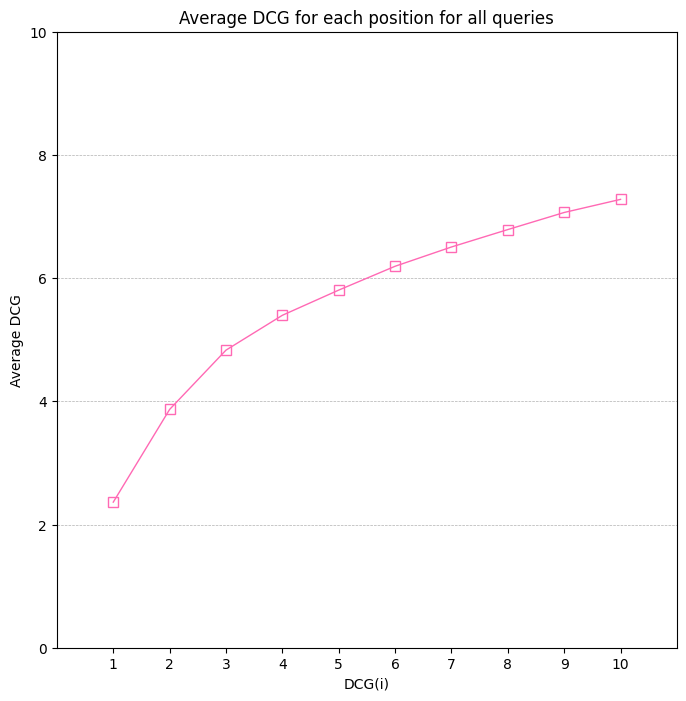

In [72]:
plt.figure(figsize=(8, 8))
plt.plot(dcg.T[99][1:], 
         marker="s", markerfacecolor="none", ms=7, color="hotpink", linewidth=1)
plt.axis([0, 11, 0, 10])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Average DCG for each position for all queries")
plt.xlabel("DCG(i)")
plt.ylabel("Average DCG")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.yticks([0, 2, 4, 6, 8, 10])
plt.savefig("../AVALIA/dcg-nostemmer-14.png")
plt.show()

In [73]:
def get_ndcg(results_docs, query_number):
    k = 10
    retrieved_docs = results_docs[query_number][:k]
    cg_vector = []
    for doc_number in retrieved_docs:
        gain = get_gain(query_number, doc_number)
        cg_vector.append(gain)
    cg_vector.sort(reverse=True)
    best_dcg = [cg_vector[0]]
    for i in range(1, k):
        dcg_i = best_dcg[i-1] + (cg_vector[i] / math.log2(i + 1))
        best_dcg.append(dcg_i)
        
    dcg = get_dcg(results_docs, query_number)
    ndcg = []
    for i in range(10):
        if best_dcg[i] != 0:
            ndcg_i = dcg[i] / best_dcg[i]
        else:
            ndcg_i = 0
        ndcg.append(ndcg_i)
    return ndcg

get_ndcg(res_docs, 1)

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.17928673655324925),
 np.float64(0.17928673655324925),
 np.float64(0.17928673655324925),
 np.float64(0.21583724568642698),
 np.float64(0.3553494439125408)]

In [74]:
def get_ndcg_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    ndcg_table = pd.DataFrame([], columns=["QueryNumber"])
    for i in range(1, 11):
        ndcg_table[i] = 0
    for index, query_number in enumerate(query_numbers):
        ndcg = get_ndcg(results_docs, query_number)
        ndcg_table.loc[index] = [query_number, *ndcg]
    return ndcg_table

ndcg = get_ndcg_table(ex_docs, res_docs)
ndcg.head()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.000,0.000000,0.000000,0.000000,0.179287,0.179287,0.179287,0.215837,0.355349
1,2.0,0.0,0.000,0.315465,0.565465,0.565465,0.565465,0.565465,0.565465,0.565465,0.565465
2,3.0,0.0,0.500,0.463449,0.463449,0.513349,0.513349,0.678433,0.678433,0.678433,0.678433
3,4.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,1.0,0.625,0.475117,0.477276,0.460082,0.508353,0.606305,0.711313,0.736158,0.736158


In [75]:
def add_mean_ndcg(ndcg_table):
    mndcg = ndcg_table
    means = []
    columns = list(mndcg.columns)[1:]
    for c in columns:
        mean = mndcg[c].sum() / len(mndcg[c])
        means.append(mean)
    mndcg.loc[len(mndcg)] = [0, *means]
    return mndcg

ndcg = add_mean_ndcg(ndcg)
ndcg.to_csv("../AVALIA/ndcg-nostemmer-16.csv")
ndcg.tail()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
95,97.0,0.000000,0.500000,0.595665,0.540981,0.540981,0.540981,0.540981,0.602183,0.718027,0.718027
96,98.0,1.000000,0.600000,0.756866,0.756866,0.756866,0.825567,0.825567,0.825567,0.825567,0.825567
97,99.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
98,100.0,1.000000,1.000000,0.760188,0.760188,0.923885,0.923885,0.923885,0.923885,0.923885,0.923885
99,0.0,0.607744,0.531746,0.555236,0.584423,0.602912,0.622765,0.646417,0.671807,0.698660,0.721505


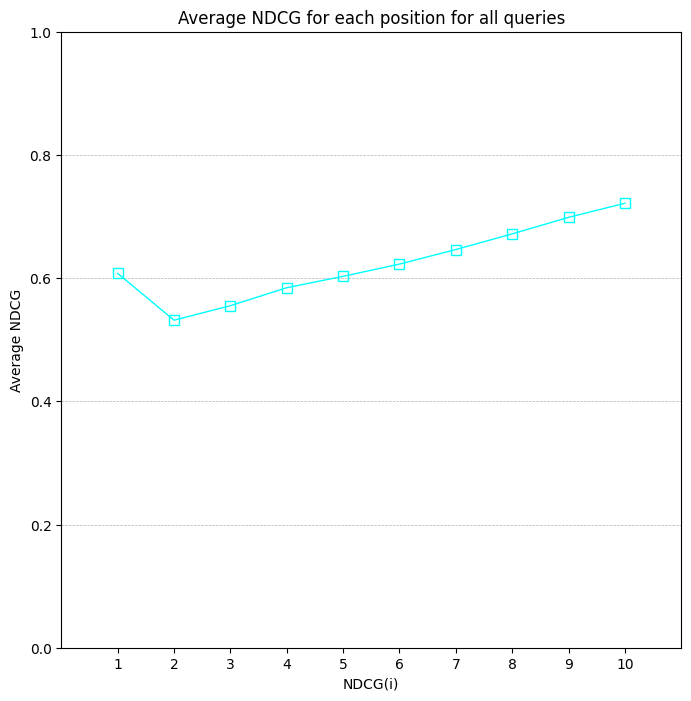

In [76]:
plt.figure(figsize=(8, 8))
plt.plot(ndcg.T[99][1:], 
         marker="s", markerfacecolor="none", ms=7, color="cyan", linewidth=1)
plt.axis([0, 11, 0, 1.0])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)
plt.title("Average NDCG for each position for all queries")
plt.xlabel("NDCG(i)")
plt.ylabel("Average NDCG")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("../AVALIA/ndcg-nostemmer-16.png")
plt.show()